# **Wood Image Classification - PyTorch Implementation**

# **Imports**

Import the required dependencies.

In [1]:
#Imports
import os
import random
import numpy as np
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import  DataLoader,Dataset
import torchvision.transforms as tt
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from datetime import datetime

import logging
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline

# 資料準備

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/Colab Notebooks/

/gdrive/MyDrive/Colab Notebooks


In [4]:
ROOT_DIR = os.getcwd()
DATA_DIR = ROOT_DIR + '/data'
%ls

 data/
'Dirty Data Generator.ipynb'
 DL_Classifier_Training-Imgaug-H004AndH005.ipynb
 DL_Classifier_Training-Imgaug.ipynb
 DL_Classifier_Training.ipynb
 Feature_Extractor_Training.ipynb
 Grad-cam.ipynb
 image-classifier-resnet9-epoch20.pth
 image-classifier-resnet9.pth
 ImgaugG.ipynb
 Imgaug.ipynb
 IntelImageClassification.ipynb
 intel-image-classification-with-pytorch.ipynb
 Intel-image-classifier-resnet50.pth
 log/
 PyTorchLightning-RayTune-Imgaug-Classifier.ipynb
 Wood_Classification.ipynb
 WoodImageClassificationImgaug.ipynb
 WoodImageClassification.ipynb
'WoodImageClassification - 複製.ipynb'
 Wood.ipynb
 wood_pytorch_model.ipynb


In [5]:
#Defining respective directories:
split_train_path = DATA_DIR + '/train/'
train_path = DATA_DIR + '/train/train/'
test_path = DATA_DIR + '/test/test/'
pred_path = DATA_DIR + '/pred/'

#classes in dataset:
classes = os.listdir(train_path)
classes

['MaSx', 'PcSx', 'TgSx', 'UpSx', 'ZzSx']

有5類資料
MaSx, PcSx, TgSx, UpSx, ZzSx

In [6]:
labels = {
    0: 'MaSx',
    1: 'PcSx',
    2: 'TgSx',
    3: 'UpSx',
    4: 'ZzSx'
}

找出training dataloader中圖片的mean和standard deviation，以方便後續正規化

In [7]:
train = ImageFolder(split_train_path, transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
]))

train_dl = DataLoader(train, 64, shuffle=True, num_workers=2, pin_memory=True)

def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
        
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl)
mean, std

(tensor([0.5285, 0.3849, 0.2674]), tensor([0.1329, 0.1208, 0.0849]))


在從訓練資料集中載入圖像時應用隨機選擇轉換。

具體來說，即將每個圖像填充 4 個像素，然後隨機裁剪大小為 64 x 64 像素的圖像，並以 50% 的機率水平翻轉圖像。由於每次載入特定圖像時都會隨機且動態地應用轉換，因此模型在每個訓練階段看到的圖像略有不同，這使得它可以更好地試到不同的情形。

In [8]:
stats = ((0.5283, 0.3847, 0.2672), (0.1330, 0.1208, 0.0850))
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])


In [9]:
train = ImageFolder(train_path, transform = train_transform)
test = ImageFolder(test_path,transform = test_transform)

將資料集分成兩部分:
- train_ds: 訓練資料
- valid_ds: 測試資料(用於測試模型準確性，這將呈現模型在從未測試過的資料集上的表現）

In [10]:
random_seed = 42
torch.manual_seed(random_seed);

In [11]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(1986, 496)

接下來，我創建了用於批量檢索圖像的dataloader。我將使用相對較大的 128 批次大小來利用較大部分的 GPU RAM。

`Note ` 如果遇到“內存不足”錯誤，可以嘗試減小批次處理大小並重新啟動內核。

In [12]:
batch_size = 128

# PyTorch data loaders
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

讓我們稍微看一下training dataloader中的一些圖片。為了顯示圖片，我們需要對像素值進行反正規化，以讓範圍回到 (0,1) 內。

In [13]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

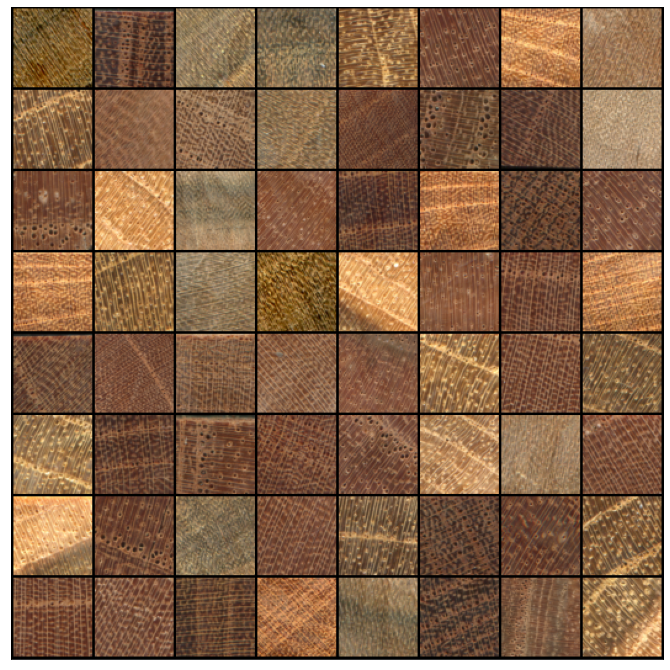

In [14]:
show_batch(train_dl)

# 一些好用的函數和類別

這裡定義了一些函數和類別來將資料搬移到 gpu 中，如此能大量節省訓練時間
另也有存log的函式


In [15]:
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

`ImageClassificationBase` 能計算loss並keep track of every epoch

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        logger.info("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

將資料移到 gpu 

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# 建立模型

這裡將延伸`ImageClassificationBase`以開發`ResNet9`模型，該模型由每兩個CNN層之後的`Residual Blocks`組成

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [21]:
no_of_classes = len(train.classes)
no_of_classes

5

In [22]:
model = to_device(ResNet9(3, no_of_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

tqdm 能顯示進度條，可以方便查看模型訓練進度

In [23]:
from tqdm.notebook import tqdm

現在準備好要訓練模型了

# 訓練模型

In [24]:
f = str(datetime.now())
temp = ROOT_DIR + '/log/' + f + '_exp01.log'
logger = get_logger(temp)
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.17760416865348816, 'val_loss': 1.6072940826416016}]

一開始，使用隨機權重，準確率為 17.76%

In [26]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [27]:
%%time
logger.info('start training!')
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
logger.info('finish training!')

[2022-03-02 14:03:59,885][<timed exec>][line:1][INFO] start training!


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:04:23,298][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [0], last_lr: 0.00099, train_loss: 0.7623, val_loss: 1.7446, val_acc: 0.6313


Epoch [0], last_lr: 0.00099, train_loss: 0.7623, val_loss: 1.7446, val_acc: 0.6313


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:04:45,778][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [1], last_lr: 0.00273, train_loss: 0.3027, val_loss: 1.1947, val_acc: 0.7359


Epoch [1], last_lr: 0.00273, train_loss: 0.3027, val_loss: 1.1947, val_acc: 0.7359


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:05:08,194][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [2], last_lr: 0.00514, train_loss: 0.2449, val_loss: 1.3035, val_acc: 0.7803


Epoch [2], last_lr: 0.00514, train_loss: 0.2449, val_loss: 1.3035, val_acc: 0.7803


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:05:30,622][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [3], last_lr: 0.00756, train_loss: 0.2987, val_loss: 24.6736, val_acc: 0.3393


Epoch [3], last_lr: 0.00756, train_loss: 0.2987, val_loss: 24.6736, val_acc: 0.3393


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:05:52,866][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [4], last_lr: 0.00935, train_loss: 0.3841, val_loss: 6.4058, val_acc: 0.5352


Epoch [4], last_lr: 0.00935, train_loss: 0.3841, val_loss: 6.4058, val_acc: 0.5352


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:06:15,270][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [5], last_lr: 0.01000, train_loss: 0.2720, val_loss: 1.1825, val_acc: 0.7542


Epoch [5], last_lr: 0.01000, train_loss: 0.2720, val_loss: 1.1825, val_acc: 0.7542


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:06:37,606][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [6], last_lr: 0.00987, train_loss: 0.1959, val_loss: 0.2977, val_acc: 0.8949


Epoch [6], last_lr: 0.00987, train_loss: 0.1959, val_loss: 0.2977, val_acc: 0.8949


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:06:59,948][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [7], last_lr: 0.00950, train_loss: 0.1335, val_loss: 0.4239, val_acc: 0.8620


Epoch [7], last_lr: 0.00950, train_loss: 0.1335, val_loss: 0.4239, val_acc: 0.8620


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:07:22,184][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [8], last_lr: 0.00891, train_loss: 0.2301, val_loss: 1.2687, val_acc: 0.7276


Epoch [8], last_lr: 0.00891, train_loss: 0.2301, val_loss: 1.2687, val_acc: 0.7276


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:07:44,591][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [9], last_lr: 0.00812, train_loss: 0.1209, val_loss: 0.0926, val_acc: 0.9697


Epoch [9], last_lr: 0.00812, train_loss: 0.1209, val_loss: 0.0926, val_acc: 0.9697


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:08:06,926][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [10], last_lr: 0.00717, train_loss: 0.2275, val_loss: 0.0921, val_acc: 0.9637


Epoch [10], last_lr: 0.00717, train_loss: 0.2275, val_loss: 0.0921, val_acc: 0.9637


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:08:29,326][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [11], last_lr: 0.00611, train_loss: 0.1034, val_loss: 0.5624, val_acc: 0.8931


Epoch [11], last_lr: 0.00611, train_loss: 0.1034, val_loss: 0.5624, val_acc: 0.8931


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:08:51,637][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [12], last_lr: 0.00500, train_loss: 0.0758, val_loss: 0.3428, val_acc: 0.8974


Epoch [12], last_lr: 0.00500, train_loss: 0.0758, val_loss: 0.3428, val_acc: 0.8974


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:09:14,088][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [13], last_lr: 0.00389, train_loss: 0.0460, val_loss: 0.6141, val_acc: 0.8427


Epoch [13], last_lr: 0.00389, train_loss: 0.0460, val_loss: 0.6141, val_acc: 0.8427


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:09:36,470][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [14], last_lr: 0.00283, train_loss: 0.0490, val_loss: 0.0559, val_acc: 0.9816


Epoch [14], last_lr: 0.00283, train_loss: 0.0490, val_loss: 0.0559, val_acc: 0.9816


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:09:58,903][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [15], last_lr: 0.00188, train_loss: 0.0425, val_loss: 0.0303, val_acc: 0.9919


Epoch [15], last_lr: 0.00188, train_loss: 0.0425, val_loss: 0.0303, val_acc: 0.9919


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:10:21,158][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [16], last_lr: 0.00109, train_loss: 0.0347, val_loss: 0.0339, val_acc: 0.9818


Epoch [16], last_lr: 0.00109, train_loss: 0.0347, val_loss: 0.0339, val_acc: 0.9818


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:10:43,591][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [17], last_lr: 0.00050, train_loss: 0.0243, val_loss: 0.0194, val_acc: 0.9898


Epoch [17], last_lr: 0.00050, train_loss: 0.0243, val_loss: 0.0194, val_acc: 0.9898


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:11:05,931][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [18], last_lr: 0.00013, train_loss: 0.0209, val_loss: 0.0144, val_acc: 0.9958


Epoch [18], last_lr: 0.00013, train_loss: 0.0209, val_loss: 0.0144, val_acc: 0.9958


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-03-02 14:11:28,305][<ipython-input-17-e293dd220bfa>][line:30][INFO] Epoch [19], last_lr: 0.00000, train_loss: 0.0197, val_loss: 0.0132, val_acc: 0.9979
[2022-03-02 14:11:28,308][<timed exec>][line:6][INFO] finish training!


Epoch [19], last_lr: 0.00000, train_loss: 0.0197, val_loss: 0.0132, val_acc: 0.9979
CPU times: user 3min 5s, sys: 2min 40s, total: 5min 46s
Wall time: 7min 28s


模型在 10 分鐘內訓練到超過 99% 的準確率！

可以再嘗試使用數據增強、網路架構調整和超參數來獲得更好的結果

繪製驗證集準確度來查看模型如何隨著時間的推移而改進。

In [28]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-o')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Accuracy vs. No. of epochs');

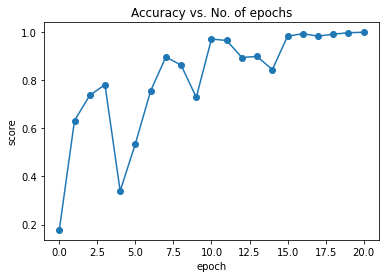

In [29]:
plot_scores(history)

還可以繪製訓練和驗證損失來查看趨勢。

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

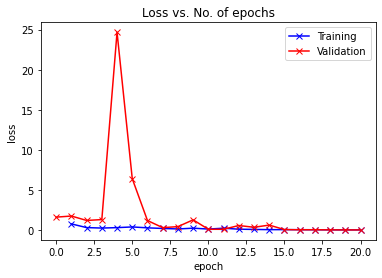

In [31]:
plot_losses(history)

從趨勢中可以清楚地看出，模型還沒有過度擬合訓練數據。

最後，視覺化 學習率是如何在所有 epoch 中逐批地隨時間變化的，。

In [32]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

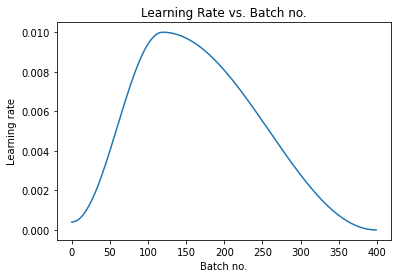

In [33]:
plot_lrs(history)

正如預期的那樣，學習率從一個低值開始，在 110 的迭代中逐漸增加到最大值 0.01，然後逐漸減小到一個非常小的值。

# 預測未測試與訓練過的資料

In [34]:
PRED_DIR = DATA_DIR + '/pred/pred/'

從預測資料集中隨機選擇圖像。

In [35]:
random_filename = random.choice([
    x for x in os.listdir(PRED_DIR)
    if os.path.isfile(os.path.join(PRED_DIR, x))
])

random_filename

'Pc2_4.tif'

將之前應用於訓練資料的相同轉換(transform)應用於此圖像

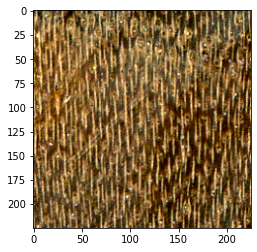

In [36]:
image = Image.open(PRED_DIR+random_filename)  
image = tt.ToTensor()(image)
plt.imshow(image.permute(1, 2, 0))
image = tt.Normalize(*stats,inplace=True)(image)

In [37]:
def predict_single(image):
    xb = image
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", decode_target(prediction, text_labels=True))
    plt.imshow(image.squeeze().permute(1, 2, 0))

In [38]:
def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

[2022-03-02 14:11:30,950][image.py][line:709][WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  PcSx(1) TgSx(2)


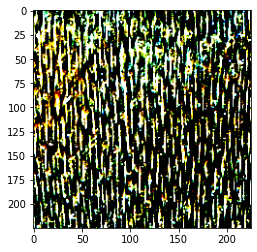

In [39]:
predict_single(image.unsqueeze(0))

In [40]:
# Save the model
torch.save(model.state_dict(), 'image-classifier-resnet9-epoch20.pth')

# 混淆矩陣

先載入model

In [41]:
model.load_state_dict(torch.load('image-classifier-resnet9-epoch20.pth'));

將測試集放入測試一下準確度

In [42]:
def predict(test_set, model):
    
    y_pred = []
    y_true = []
    
    model.to(device).eval()
    
    test_loader = DataLoader(test_set, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images = images.to(device)
            target = target.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)
            
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(target.view(-1).detach().cpu().numpy())
        
    return y_pred, y_true

In [43]:
def plot_matrix(cm, classes):

    fig, ax= plt.subplots(figsize = (5, 4))
    sns.heatmap(cm, fmt='.2%', cmap="OrRd", annot=True, vmax=1, ax=ax)
    ax.set_yticklabels(classes, rotation=0)
    ax.set_xticklabels(classes, rotation=90)
    plt.show()

In [44]:
train_set = ImageFolder(train_path, train_transform)
val_set = ImageFolder(test_path, test_transform)

In [45]:
train_pred, train_label,  = predict(train_ds, model)
val_pred, val_label = predict(val_ds, model)
test_pred, test_label = predict(test, model)

In [46]:
train_ds

Training acc.: 99.80 %


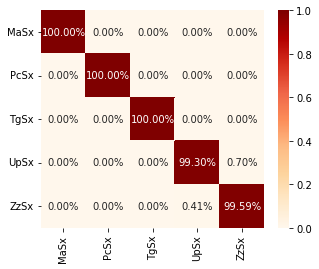

In [47]:
print("Training acc.: {:.2f} %".format(accuracy_score(train_label, train_pred)*100))
plot_matrix(confusion_matrix(train_label, train_pred, normalize='true'), classes=train.classes)

Validation acc.: 99.60 %


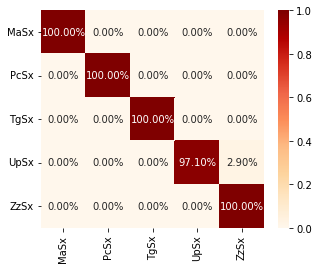

In [48]:
print("Validation acc.: {:.2f} %".format(accuracy_score(val_label, val_pred)*100))
plot_matrix(confusion_matrix(val_label, val_pred, normalize='true'), classes=train.classes)

Test acc.: 98.73 %


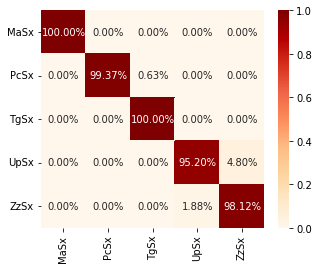

In [49]:
print("Test acc.: {:.2f} %".format(accuracy_score(test_label, test_pred)*100))
plot_matrix(confusion_matrix(test_label, test_pred, normalize='true'), classes=train.classes)